# Topic Extraction on Bokan & Comperitors 

## Goals
- Extract and get meaningful topics from 5* reviews of key competitors -> Wordcloud for each topic -> ideas for rebranding
- Extract topics from Bokan's bad reviews -> Wordcloud for each topic -> focus on when rebranding
- Extract topics from Bokan's good reviews -> Wordcloud for each topic -> put forward when advertizing

## Outline
- Import Libraries
- Load and preprocess the data
- Topic Extraction
    - Topic extraction from competitors good reviews using LDA with gensim 
    - Topic extraction from bokan bad reviews using GSDMM & conclusions
    - Topic extraction from bokan good reviews using GSDMM & conclusions

## Import libraries 

In [5]:
#!git clone https://github.com/rwalk/gsdmm
#!pip install transformers==2.4.1
#!pip install flair

Cloning into 'gsdmm'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), done.
     |████████████████████████████████| 256kB 274kB/s eta 0:00:01


  Found existing installation: pytest 5.1.2
    Uninstalling pytest-5.1.2:
      Successfully uninstalled pytest-5.1.2


In [6]:
import os
import numpy as np
import pandas as pd
import pickle
import gensim
import gensim.corpora as corpor
import pyLDAvis.gensim
import pyLDAvis
from gsdmm.gsdmm import MovieGroupProcess
from gensim.models.coherencemodel import CoherenceModel
import operator
from tqdm import tqdm_notebook as tqdm
import flair
import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message
/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.u

In [7]:
nltk.download('vader_lexicon')
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/naomi/nltk_data...


2020-03-15 15:44:40,602 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/models-v0.4/classy-imdb-en-rnn-cuda%3A0/imdb-v0.4.pt not found in cache, downloading to /var/folders/l6/zm_0tmgn0t7_n8nbqxblbqmm0000gn/T/tmpdakrgriq


100%|██████████| 1501979561/1501979561 [01:33<00:00, 16129671.92B/s]

2020-03-15 15:46:13,934 copying /var/folders/l6/zm_0tmgn0t7_n8nbqxblbqmm0000gn/T/tmpdakrgriq to cache at /Users/naomi/.flair/models/imdb-v0.4.pt


2020-03-15 15:46:17,613 removing temp file /var/folders/l6/zm_0tmgn0t7_n8nbqxblbqmm0000gn/T/tmpdakrgriq
2020-03-15 15:46:17,859 loading file /Users/naomi/.flair/models/imdb-v0.4.pt


## Load and reprocess the data 

In [8]:
from data import jl_to_df

In [9]:
bokan_37 = jl_to_df.read_jl_file("data/Bokan_37.jl")
bokan_38_39 = jl_to_df.read_jl_file("data/Bokan_38_39.jl")
boisdale = jl_to_df.read_jl_file("data/Boisdale.jl")
cinnamon = jl_to_df.read_jl_file("data/Cinnamon.jl")
ivy = jl_to_df.read_jl_file("data/Ivy.jl")
peninsula = jl_to_df.read_jl_file("data/Peninsula.jl")

In [10]:
# Put all the reviews of bokan and competitors in two dataframes
document_competitors = pd.concat([boisdale, cinnamon, ivy, peninsula], axis = 0)
document_bokan = pd.concat([bokan_37, bokan_38_39], axis = 0)
document_competitors.rating = document_competitors.rating.astype(int)
document_bokan.rating = document_bokan.rating.astype(int)

In [11]:
# Check if the dataframes was correctly created
print(len(document_competitors) == sum(map(lambda x: len(x),[boisdale, cinnamon, ivy, peninsula])))
print(len(document_bokan) == sum(map(lambda x: len(x),[bokan_37, bokan_38_39])))

True
True


In [12]:
document_competitors.head()

,id_resto,id_comment,resto,resto_url,rating,title,diner_date,rating_date,answer_text,reviewer_pseudo,reviewer_origin,reviewer_info_sup,other_ratings_category,other_ratings_value,url,content
0,g186338-d2180904,g186338-d2180904-r747618087,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,4,Fabulous ambience and delightful service from ...,February 2020,25 February 2020,None,Hopesprings1,"[Sunningdale, United Kingdom]","[[pencil-paper, 2]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,"[Fabulous food, service and old school live Ja..."
1,g186338-d2180904,g186338-d2180904-r744514687,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,4,Upscale McDonalds,February 2020,12 February 2020,None,futtock21,"[London, United Kingdom]","[[pencil-paper, 2802], [thumbs-up-fill, 1252]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[Boisdale Canary Wharf is part of a coterie of...
2,g186338-d2180904,g186338-d2180904-r743436725,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,4,Good night out!,January 2020,6 February 2020,None,Jan S,"[Hornchurch, United Kingdom]","[[pencil-paper, 94], [thumbs-up-fill, 54]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[My first visit to Boisdale. I visited on a Fr...
3,g186338-d2180904,g186338-d2180904-r743081178,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,5,"Very good, will return",February 2020,4 February 2020,None,tripbiscuit,"[London, UK]","[[pencil-paper, 113], [thumbs-up-fill, 83]]","[Value, Service, Food]","[50, 50, 50]",https://www.tripadvisor.co.uk/ShowUserReviews-...,[I took advantage of a groupon offer as I was ...
4,g186338-d2180904,g186338-d2180904-r744537071,Boisdale_Canary_Wharf,/Restaurant_Review-g186338-d2180904-Reviews-Bo...,3,Boisdale,February 2020,12 February 2020,None,grahamm586,[],"[[pencil-paper, 3]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[Not very busy when we visited. Service pretty...


In [13]:
# We are only interested in 5 star ratings from competitors
document_competitors = document_competitors.loc[document_competitors.rating == 5, :]

# And we split bokan review into very good (5 stars) and very bad (<= 2stars)
document_bokan_good = document_bokan.loc[document_bokan.rating == 5, :]
document_bokan_bad = document_bokan.loc[document_bokan.rating <= 2, :]

In [14]:
document_bokan_bad.head()

,id_resto,id_comment,resto,resto_url,rating,title,diner_date,rating_date,answer_text,reviewer_pseudo,reviewer_origin,reviewer_info_sup,other_ratings_category,other_ratings_value,url,content
2,g186338-d12156905,g186338-d12156905-r741474592,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,2,Much better out there......,January 2020,27 January 2020,[Thank you Kevin T for sharing your experience...,satanbug,"[Auckland, New Zealand]","[[pencil-paper, 528], [thumbs-up-fill, 170]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[We were on site so decided to visit. We share...
5,g186338-d12156905,g186338-d12156905-r741502709,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,2,Disappointed,January 2020,27 January 2020,[Thank you Elena T for your review. I have spo...,elenatX4465YE,"[London, United Kingdom]","[[pencil-paper, 6], [thumbs-up-fill, 5]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[I dined here with friends on a Saturday night...
17,g186338-d12156905,g186338-d12156905-r734982490,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,1,Christmas Disasters,December 2019,27 December 2019,[Thank you for your feedback Yvonne G. I am sl...,Yvonne G,"[Croydon, United Kingdom]","[[pencil-paper, 72], [thumbs-up-fill, 72]]","[Value, Service, Food]","[10, 10, 10]",https://www.tripadvisor.co.uk/ShowUserReviews-...,[I booked Bokan Christmas dinner because we we...
18,g186338-d12156905,g186338-d12156905-r709002464,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,2,"Ok food, terrible service",September 2019,12 September 2019,"[Thank you Claire, I am so sorry about this an...",ClaireCur,[],"[[pencil-paper, 1], [thumbs-up-fill, 1]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,[My husband and I were staying at the Novotel ...
23,g186338-d12156905,g186338-d12156905-r708642279,Bokan_37_Restaurant,/Restaurant_Review-g186338-d12156905-Reviews-B...,1,"Good view, bad service",September 2019,10 September 2019,[Thank you for your review. I am so sad and di...,danielcO2200BQ,[],"[[pencil-paper, 1], [thumbs-up-fill, 2]]",[],[],https://www.tripadvisor.co.uk/ShowUserReviews-...,"[We had really bad service, change of courses ..."


In [15]:
print("Bokan bad: " ,len(document_bokan_bad))
print("Bokan good: " ,len(document_bokan_good))
print("Competitors: " ,len(document_competitors))

Bokan bad:  70
Bokan good:  320
Competitors:  969


In [16]:
# These are all the 5 star reviews from competitors 
content_competitors = document_competitors.content
# And these are good and bad reviews for bokan
content_bokan_good = document_bokan_good.content
content_bokan_bad = document_bokan_bad.content

In [17]:
content_bokan_bad.head()

2     [We were on site so decided to visit. We share...
5     [I dined here with friends on a Saturday night...
17    [I booked Bokan Christmas dinner because we we...
18    [My husband and I were staying at the Novotel ...
23    [We had really bad service, change of courses ...
Name: content, dtype: object

In [18]:
content_competitors.index = range(0, len(content_competitors))
content_bokan_good.index = range(0, len(content_bokan_good))
content_bokan_bad.index = range(0, len(content_bokan_bad))

In [19]:
# Transform reviews into strings
content_competitors = content_competitors.apply(lambda x: "".join(x))
content_bokan_good = content_bokan_good.apply(lambda x: "".join(x))
content_bokan_bad = content_bokan_bad.apply(lambda x: "".join(x))

In [20]:
content_bokan_good

0      Highly recommend the food! The most amazing lo...
1      Whaou It’s really really good, We’re passionne...
2      My brother and I went to Bokan for dinner last...
3      We went to dinner with my partner in this rest...
4      Took my friend for her birthday it was one of ...
                             ...                        
315    We are staying at the hotel, had lunch here. O...
316    I went on a walk on Sunday evening and was not...
317    Spotted this place whilst staying at neighbour...
318    Both bars very nice, decor lovely, views amazi...
319    The atmosphere here was lovely. The view was t...
Name: content, Length: 320, dtype: object

In [21]:
# Split reviews into sentences
content_competitors = content_competitors.apply(lambda x: x.split(". "))
content_bokan_good = content_bokan_good.apply(lambda x: x.split(". "))
content_bokan_bad = content_bokan_bad.apply(lambda x: x.split(". "))

In [22]:
# Put all sentences in a big list for each df
l_competitors = []
l_bokan_good = []
l_bokan_bad = []
for i in content_competitors:
    l_competitors += i
for i in content_bokan_good:
    l_bokan_good += i
for i in content_bokan_bad:
    l_bokan_bad += i

In [23]:
# Transpose the lists into dataframe of sentences
data_competitors = pd.DataFrame(l_competitors, columns=["content"])
print(data_competitors.head())
print("\n")
data_bokan_good = pd.DataFrame(l_bokan_good, columns=["content"])
print(data_bokan_good.head())
print("\n")
data_bokan_bad = pd.DataFrame(l_bokan_bad, columns=["content"])
print(data_bokan_bad.head())
data_bokan_bad.to_csv(r'bokan_bad.csv')

                                             content
0  I took advantage of a groupon offer as I was m...
1  We've both passed it many times on the way to ...
2  Anyway, it's a very nice space, upmarket brass...
3  It looks as if they can cater for private part...
4  Service was charming and attentive, the wine l...


                                             content
0  Highly recommend the food! The most amazing lo...
1  Whaou It’s really really good, We’re passionne...
2  My brother and I went to Bokan for dinner last...
3                        Then the service, brilliant
4  Professional, precise, very knowledgeable and ...


                                             content
0                We were on site so decided to visit
1  We shared a few starters and a main with a cou...
2  We arrived as the restaurant opened and were t...
3  Hopeless...The starters were good, we enjoyed ...
4  For close to £ 300 pounds you would expect muc...


In [24]:
# Cleaning, Tokenization & Stemming functions from last notebooks
def basic_cleaning(series):
    # Remove punctuation
    new_series = series.str.replace('[^\w\s]','')
    # Strip trailing whitespace
    new_series = new_series.str.strip(" ")
    # Decapitalize letters
    new_series = new_series.apply(lambda x: str(x).lower())
    return new_series

def tokenize_filter(sentence):
    # Define stopwords
    stop_words = set(stopwords.words('english')) 
    ## Add personalised stop words
    stop_words |= set(["london", "food", "drink", "restaurant"])
    # Filter the sentence
    word_tokens = word_tokenize(sentence) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return (word_tokens, filtered_sentence)

def stem_review(tokens):
    porter = PorterStemmer()
    return tokens.apply(lambda x: [porter.stem(x[i]) for i in range(len(x))])

def lemmatize_review(tokens):
    lemmatizer = WordNetLemmatizer()
    return tokens.apply(lambda x: [lemmatizer.lemmatize(x[i]) for i in range(len(x))])

def preprocess_data(data):
    df = data
    df["cleaned_content"] = basic_cleaning(df["content"])
    df["tokenized_content"] = df["cleaned_content"].apply(lambda x: tokenize_filter(x)[1])
    df["clean_content"] = lemmatize_review(df["tokenized_content"])
    return df[["clean_content"]]

df_competitors = preprocess_data(data_competitors)
df_bokan_good = preprocess_data(data_bokan_good)
df_bokan_bad = preprocess_data(data_bokan_bad)

<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-24-d2348413c420>:4: DeprecationWarning: invalid escape sequence \w
  new_series = series.str.replace('[^\w\s]','')


In [25]:
print(df_competitors.head())
print("\n")
print(df_bokan_good.head())
print("\n")
print(df_bokan_bad.head())

                                       clean_content
0  [took, advantage, groupon, offer, meeting, fri...
1  [weve, passed, many, time, way, somewhere, els...
2  [anyway, nice, space, upmarket, brasseriestyle...
3       [look, cater, private, party, larger, group]
4  [service, charming, attentive, wine, list, go,...


                                       clean_content
0  [highly, recommend, amazing, location, best, c...
1  [whaou, really, really, good, passionned, good...
2  [brother, went, bokan, dinner, last, week, ill...
3                               [service, brilliant]
4  [professional, precise, knowledgeable, lovely,...


                                       clean_content
0                             [site, decided, visit]
1        [shared, starter, main, couple, cold, beer]
2  [arrived, opened, told, two, lobster, left, fa...
3  [hopelessthe, starter, good, enjoyed, main, fi...
4  [close, 300, pound, would, expect, much, much,...


## Topic extraction 

### Topic extraction from competitors good reviews using LDA with gensim 

In [26]:
# Dictionary
tokens = df_competitors.clean_content
dictionary = gensim.corpora.Dictionary(tokens)
# Filter out tokens in the dictionary by their frequency
dictionary.filter_extremes(no_below=0.05, no_above=0.9)
# doc2bow: Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(tok) for tok in tokens]

In [27]:
ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=3, 
                                           random_state=41,
                                           alpha=0.1,
                                           eta=0.1,
                                           per_word_topics=True)

In [63]:
compet_good_reviews = {}
for i,topic in ldaModel.show_topics(formatted=True, num_topics=3, num_words=50):
    print(str(i)+": "+ topic+"\n")
    compet_good_reviews[i] = topic

0: 0.025*"staff" + 0.021*"wine" + 0.019*"service" + 0.016*"menu" + 0.015*"would" + 0.011*"friendly" + 0.011*"definitely" + 0.010*"back" + 0.010*"excellent" + 0.010*"tasting" + 0.010*"well" + 0.009*"recommend" + 0.009*"course" + 0.008*"hotel" + 0.008*"night" + 0.008*"meal" + 0.008*"go" + 0.008*"delicious" + 0.008*"really" + 0.008*"presented" + 0.008*"attentive" + 0.006*"dish" + 0.006*"good" + 0.006*"best" + 0.006*"lovely" + 0.006*"chef" + 0.006*"enjoyed" + 0.006*"highly" + 0.006*"view" + 0.005*"peninsula" + 0.005*"taste" + 0.005*"o2" + 0.005*"amazing" + 0.005*"great" + 0.005*"evening" + 0.005*"professional" + 0.004*"nice" + 0.004*"time" + 0.004*"u" + 0.004*"special" + 0.004*"tasty" + 0.004*"star" + 0.004*"helpful" + 0.004*"visit" + 0.004*"michelin" + 0.004*"worth" + 0.004*"even" + 0.003*"experience" + 0.003*"say" + 0.003*"dinner"

1: 0.016*"great" + 0.012*"place" + 0.011*"birthday" + 0.010*"well" + 0.009*"staff" + 0.009*"nice" + 0.009*"friend" + 0.008*"service" + 0.008*"wine" + 0.008*"e

In [29]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, texts=tokens ,coherence="c_v")
cm.get_coherence()

0.30473726857285466

In [30]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.042880  0.098485       1        1  43.271126
0     -0.074646 -0.082206       2        1  35.441059
1      0.117525 -0.016280       3        1  21.287819, topic_info=           Term        Freq       Total Category  logprob  loglift
53         wine  395.000000  395.000000  Default  30.0000  30.0000
196       staff  512.000000  512.000000  Default  29.0000  29.0000
109        view  504.000000  504.000000  Default  28.0000  28.0000
113       great  630.000000  630.000000  Default  27.0000  27.0000
8         place  209.000000  209.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
372        meal   45.049679  256.856812   Topic3  -5.2385  -0.1937
362  experience   42.793327  204.483185   Topic3  -5.2898  -0.0171
436      dinner   42.613728  219.121933   Topic3  -5.2940  -0.0904
74         good   44.952110  333.447998   Topic3  -5.2406  -0.4569
129        menu   43.460587  466.520325   Topic3  -5.2744  -0.8264

[263 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3224      3  1.027634     18
4864      1  0.968262   18th
2421      3  1.026764    200
2609      2  0.995966     40
1976      1  0.067623      6
...     ...       ...    ...
2238      2  1.001764   word
95        1  0.148409  would
95        2  0.676087  would
95        3  0.171495  would
1513      3  1.028254   youd

[410 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

**Conclusion for topic extraction on competitors 5 star reviews**
- Topics are not clear
- Further manual analysis required to find the features that competitors have and that we are missing

### Topic extraction from bokan bad reviews using GSDMM 

In [186]:
# Dictionary
tokens = df_bokan_bad.clean_content
dictionary = gensim.corpora.Dictionary(tokens)
# Filter out tokens in the dictionary by their frequency
dictionary.filter_extremes(no_below=0.05, no_above=0.9)
# doc2bow: Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(tok) for tok in tokens]

In [187]:
df_bokan_bad['nb_token'] = list(map(len, df_bokan_bad['clean_content']))
docs = df_bokan_bad.clean_content.to_list()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [188]:
nb_topic = 3
alpha = 0.1
beta = 0.1

mgpModel = MovieGroupProcess(K=nb_topic, alpha=alpha, beta=beta, n_iters=20)
mgpModelFit = mgpModel.fit(tokens, n_terms)

# Save model
#with open(f'model/gsdmm_model.pkl', 'wb') as f:
#    pickle.dump(mgpModel, f)
#    f.close()

In stage 0: transferred 325 clusters with 3 clusters populated
In stage 1: transferred 167 clusters with 3 clusters populated
In stage 2: transferred 116 clusters with 3 clusters populated
In stage 3: transferred 103 clusters with 3 clusters populated
In stage 4: transferred 118 clusters with 3 clusters populated
In stage 5: transferred 109 clusters with 3 clusters populated
In stage 6: transferred 117 clusters with 3 clusters populated
In stage 7: transferred 107 clusters with 3 clusters populated
In stage 8: transferred 102 clusters with 3 clusters populated
In stage 9: transferred 92 clusters with 3 clusters populated
In stage 10: transferred 97 clusters with 3 clusters populated
In stage 11: transferred 93 clusters with 3 clusters populated
In stage 12: transferred 113 clusters with 3 clusters populated
In stage 13: transferred 109 clusters with 3 clusters populated
In stage 14: transferred 97 clusters with 3 clusters populated
In stage 15: transferred 106 clusters with 3 clusters 

In [189]:
def topWordsPerTopic(clusterDistrib, topIndex, nbWord):
    for index in topIndex:
        clusterWord = clusterDistrib[index]
        sortedCluster = sorted(clusterWord.items(), key=operator.itemgetter(1), reverse=True)
        clusterTopWords = sortedCluster[:nbWord]
        print(f"Cluster {index} : {clusterTopWords}")
        print('*'*20)

**QUESTION:** Can we do a wordcloud on the clusters?

In [190]:
docCount = np.array(mgpModel.cluster_doc_count)
print('Number of documents per topic :', docCount)
print('*'*20)
# Topics sorted by the number of document they are allocated to
topIndex = docCount.argsort()[::-1]
print('Most important clusters (by number of docs inside):', topIndex)
print('*'*20)
# Show the top 30 words in term frequency for each cluster 
cluster_bokan_bad = topWordsPerTopic(mgpModel.cluster_word_distribution, topIndex, 30)

Number of documents per topic : [147 225 218]
********************
Most important clusters (by number of docs inside): [1 2 0]
********************
Cluster 1 : [('bar', 42), ('u', 36), ('staff', 27), ('time', 24), ('service', 24), ('didnt', 23), ('one', 21), ('night', 20), ('table', 19), ('good', 19), ('bokan', 18), ('really', 17), ('great', 17), ('would', 15), ('even', 15), ('like', 15), ('could', 15), ('experience', 15), ('around', 13), ('drink', 13), ('view', 12), ('place', 12), ('customer', 12), ('friend', 12), ('said', 12), ('floor', 12), ('venue', 12), ('waiter', 10), ('amazing', 10), ('canary', 10)]
********************
Cluster 2 : [('drink', 40), ('time', 34), ('table', 34), ('bar', 29), ('order', 27), ('u', 26), ('ordered', 24), ('view', 21), ('arrived', 19), ('cocktail', 19), ('asked', 18), ('staff', 18), ('main', 17), ('however', 17), ('minute', 15), ('service', 15), ('waiting', 15), ('got', 15), ('another', 13), ('friend', 13), ('came', 13), ('menu', 12), ('waiter', 12), ('

### pyLDAvis with gsdmm

In [36]:
#Topic-term matrix shape (n_topic, n_term)
def createTopicTermMatrix(vocab, mgp):
    zero = np.zeros((len(mgp.cluster_word_distribution), len(vocab)))
    df = pd.DataFrame(data=zero, columns=list(vocab))
    for i, cluster_word_distrib in tqdm(enumerate(mgp.cluster_word_distribution)):
        for key, val in cluster_word_distrib.items():
            df.loc[i, key] = val
    return df

In [37]:
TopicTermMatrix = createTopicTermMatrix(vocab, mgpModel)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [38]:
#Matrix of document-topic probabilities shape (n_doc, n_topics)
def createDocumentTopicProbaMatrix(mgp, doc_list):
    score_per_doc = []
    for doc in tqdm(doc_list):
        score_per_doc.append(mgp.score(doc))
    df = pd.DataFrame(data=score_per_doc, columns=[i for i in range(nb_topic)])
    return df

In [39]:
probaDocumentTopicMatrix = createDocumentTopicProbaMatrix(mgpModel, docs)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [40]:
def deleteNonProcessedDocument(probaDocumentTopicMatrix, document):
    check = probaDocumentTopicMatrix.sum(axis=1)
    toDelete = check[check==0]
    idxToDelete = toDelete.index 
    probaDocumentTopicMatrix = probaDocumentTopicMatrix.drop(idxToDelete)
    
    idx = list(map(lambda x: document.index[x], idxToDelete))
    document = document.drop(idx)
    return probaDocumentTopicMatrix, document

In [41]:
probaDocumentTopicMatrixClean, documentClean = deleteNonProcessedDocument(probaDocumentTopicMatrix, df_bokan_bad)

In [42]:
#doc length shape (n_doc)
docLength = documentClean.nb_token
print(len(documentClean))

590


In [43]:
#doc length shape (n_term)
vocabList = list(vocab) 

In [44]:
#Term frequency shape (n_term)
def TermFrequency(vocab_list, doc_list):
    res = []
    for word in tqdm(vocab_list):
        word_per_doc = sum(list(map(lambda x: x.count(word), doc_list)))
        res.append(word_per_doc)
    return res

In [45]:
termFrequencyList = TermFrequency(vocabList, docs)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [46]:
%%time
vis = pyLDAvis.prepare(TopicTermMatrix, probaDocumentTopicMatrixClean, docLength, vocabList, termFrequencyList, sort_topics=False)
pyLDAvis.display(vis)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


CPU times: user 1.03 s, sys: 13.7 ms, total: 1.05 s
Wall time: 1.49 s


**Conclusion: Topic extraction for bad reviews of bokan**
- **Topic 1: Time:** reservation time, time to get the menu, time to get the drinks, service time --> more staff, time guarantees for service
- **Topic 2: Food:** cold, not well cooked, several dishes that come up frequently like duck, fish etc, to be analyzed semi-manually
- **Topic 3: Staff:** rude, not appologizing when mistake is made --> formation, réecriture de l'énoncé de mission personelle pour le restaurant par les employés eux-mêmes

## Topic extraction from bokan good reviews using GSDMM 

In [47]:
# Dictionary
tokens = df_bokan_good.clean_content
dictionary = gensim.corpora.Dictionary(tokens)
# Filter out tokens in the dictionary by their frequency
dictionary.filter_extremes(no_below=0.05, no_above=0.9)
# doc2bow: Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(tok) for tok in tokens]

In [48]:
df_bokan_good['nb_token'] = list(map(len, df_bokan_good['clean_content']))
docs = df_bokan_good.clean_content.to_list()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
nb_topic = 3
alpha = 0.1
beta = 0.1

mgpModel = MovieGroupProcess(K=nb_topic, alpha=alpha, beta=beta, n_iters=20)
mgpModelFit = mgpModel.fit(tokens, n_terms)

In stage 0: transferred 786 clusters with 3 clusters populated
In stage 1: transferred 482 clusters with 3 clusters populated
In stage 2: transferred 380 clusters with 3 clusters populated
In stage 3: transferred 291 clusters with 3 clusters populated
In stage 4: transferred 275 clusters with 3 clusters populated
In stage 5: transferred 285 clusters with 3 clusters populated
In stage 6: transferred 273 clusters with 3 clusters populated
In stage 7: transferred 229 clusters with 3 clusters populated
In stage 8: transferred 236 clusters with 3 clusters populated
In stage 9: transferred 215 clusters with 3 clusters populated
In stage 10: transferred 245 clusters with 3 clusters populated
In stage 11: transferred 236 clusters with 3 clusters populated
In stage 12: transferred 264 clusters with 3 clusters populated
In stage 13: transferred 225 clusters with 3 clusters populated
In stage 14: transferred 205 clusters with 3 clusters populated
In stage 15: transferred 213 clusters with 3 clust

In [69]:
def topWordsPerTopic(clusterDistrib, topIndex, nbWord):
    l = []
    for index in topIndex:
        clusterWord = clusterDistrib[index]
        sortedCluster = sorted(clusterWord.items(), key=operator.itemgetter(1), reverse=True)
        clusterTopWords = sortedCluster[:nbWord]
        print(f"Cluster {index} : {clusterTopWords}")
        print('*'*20)
        l.append(clusterTopWords)
    return l

**QUESTION:** Can we do a wordcloud on the clusters?

In [73]:
docCount = np.array(mgpModel.cluster_doc_count)
print('Number of documents per topic :', docCount)
print('*'*20)
# Topics sorted by the number of document they are allocated to
topIndex = docCount.argsort()[::-1]
print('Most important clusters (by number of docs inside):', topIndex)
print('*'*20)
# Show the top 30 words in term frequency for each cluster 
cluster_bokan_good = topWordsPerTopic(mgpModel.cluster_word_distribution, topIndex, 30)

Number of documents per topic : [337 444 594]
********************
Most important clusters (by number of docs inside): [2 1 0]
********************
Cluster 2 : [('view', 209), ('great', 97), ('staff', 88), ('service', 84), ('amazing', 80), ('friendly', 57), ('bar', 55), ('place', 54), ('definitely', 49), ('really', 47), ('would', 45), ('recommend', 44), ('bokan', 43), ('drink', 41), ('good', 40), ('cocktail', 40), ('nice', 38), ('back', 36), ('go', 34), ('city', 31), ('highly', 31), ('well', 31), ('excellent', 29), ('floor', 29), ('atmosphere', 28), ('beautiful', 28), ('canary', 28), ('stunning', 27), ('night', 27), ('wharf', 27)]
********************
Cluster 1 : [('view', 66), ('bar', 66), ('table', 57), ('bokan', 56), ('u', 55), ('time', 46), ('floor', 43), ('amazing', 37), ('staff', 37), ('went', 35), ('dinner', 32), ('great', 31), ('hotel', 31), ('place', 30), ('one', 27), ('visit', 27), ('day', 27), ('canary', 25), ('would', 25), ('best', 24), ('wharf', 24), ('brunch', 23), ('birt

### pyLDAvis with gsdmm

In [52]:
#Topic-term matrix shape (n_topic, n_term)
def createTopicTermMatrix(vocab, mgp):
    zero = np.zeros((len(mgp.cluster_word_distribution), len(vocab)))
    df = pd.DataFrame(data=zero, columns=list(vocab))
    for i, cluster_word_distrib in tqdm(enumerate(mgp.cluster_word_distribution)):
        for key, val in cluster_word_distrib.items():
            df.loc[i, key] = val
    return df

In [53]:
TopicTermMatrix = createTopicTermMatrix(vocab, mgpModel)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [54]:
#Matrix of document-topic probabilities shape (n_doc, n_topics)
def createDocumentTopicProbaMatrix(mgp, doc_list):
    score_per_doc = []
    for doc in tqdm(doc_list):
        score_per_doc.append(mgp.score(doc))
    df = pd.DataFrame(data=score_per_doc, columns=[i for i in range(nb_topic)])
    return df

In [55]:
probaDocumentTopicMatrix = createDocumentTopicProbaMatrix(mgpModel, docs)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [56]:
def deleteNonProcessedDocument(probaDocumentTopicMatrix, document):
    check = probaDocumentTopicMatrix.sum(axis=1)
    toDelete = check[check==0]
    idxToDelete = toDelete.index 
    probaDocumentTopicMatrix = probaDocumentTopicMatrix.drop(idxToDelete)
    
    idx = list(map(lambda x: document.index[x], idxToDelete))
    document = document.drop(idx)
    return probaDocumentTopicMatrix, document

In [57]:
probaDocumentTopicMatrixClean, documentClean = deleteNonProcessedDocument(probaDocumentTopicMatrix, df_bokan_good)

In [58]:
#doc length shape (n_doc)
docLength = documentClean.nb_token
print(len(documentClean))

1375


In [59]:
#doc length shape (n_term)
vocabList = list(vocab) 

In [60]:
#Term frequency shape (n_term)
def TermFrequency(vocab_list, doc_list):
    res = []
    for word in tqdm(vocab_list):
        word_per_doc = sum(list(map(lambda x: x.count(word), doc_list)))
        res.append(word_per_doc)
    return res

In [61]:
termFrequencyList = TermFrequency(vocabList, docs)

/Users/naomi/bin/anaconda/envs/py4business/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [62]:
%%time
vis = pyLDAvis.prepare(TopicTermMatrix, probaDocumentTopicMatrixClean, docLength, vocabList, termFrequencyList, sort_topics=False)
pyLDAvis.display(vis)

CPU times: user 1.43 s, sys: 15.6 ms, total: 1.45 s
Wall time: 1.94 s


**Conclusion: Topic extraction for good reviews of bokan**
- **Topic 1: Staff:** attentive, friendly, great service --> shows that some waiters do a really good job and highlights the fact that some waiters are more welcoming than others
- **Topic 2: Food:** delicious, tasty, well presented, several dishes that come up frequently like lamb, some cocktails and some desserts, to be analyzed semi-manually
- **Topic 3: View:** unanimously liked by all customers, should be put forward when advertizing for Bokan

# Wordcloud

## Get sentences from cluster and topic

In [181]:
a = ' '.join(list(map(lambda x : x[1]*(x[0]+' '), cluster_bokan_bad[0])))

In [166]:
#cluster_bokan_good

## Do wordcloud

In [146]:
!ls fig

coffee.jpg plate2.jpg waiter.jpg


In [157]:
from wordcloud import WordCloud
from PIL import Image
FIG_PATH = 'fig/'

# Function to generate word cloud from corpusfrom_corpus_to_word_cloud(scrapped_data['clean_title'])
def from_corpus_to_word_cloud(text_column, im_path):
    image = Image.open(FIG_PATH + im_path)
    mask = np.array(image)
    #text_column = text_column.to_string()
    # Generate a word cloud image
    wc = WordCloud(background_color="white",min_font_size=7, mask=mask, collocations = False)
    # Setting max font size to 50 to display more words
    wordcloud = wc.generate(text_column)
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 10))
    #plt.pyplot.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show() 
    return wordcloud


###### Wordcloud for good reviews of competitors

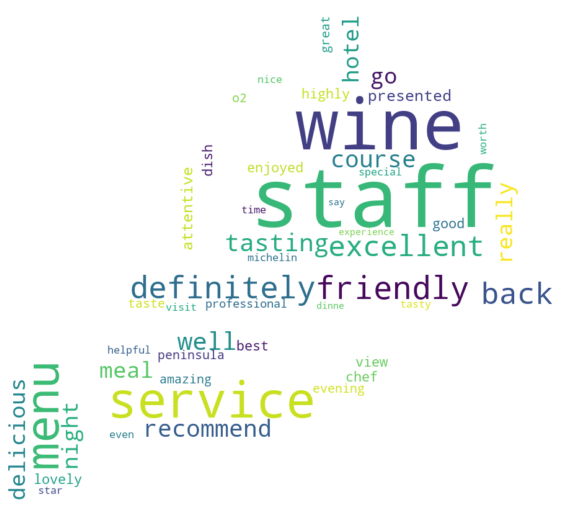

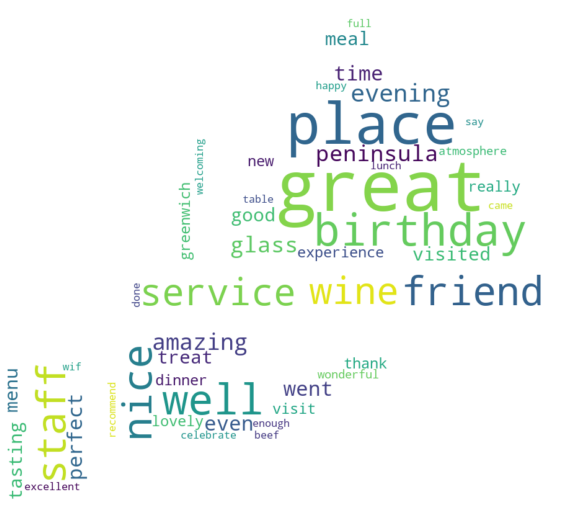

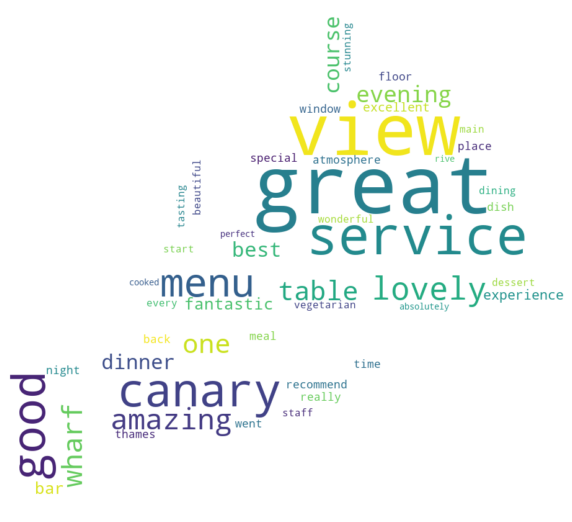

In [172]:
for i in range(3):
    topic= ' '.join(list(map(lambda x : (int(float(x.split('*')[0])*1000)*(' '+(x.split('*')[1])[1:-2])) , compet_good_reviews[i].split('+'))))
    from_corpus_to_word_cloud(topic, 'waiter.jpg')

###### Wordclouf for bad reviews of Bokan

In [192]:
for i in range(3):
    cluster = ' '.join(list(map(lambda x : x[1]*(x[0]+' '), cluster_bokan_bad[i])))
    from_corpus_to_word_cloud(cluster,'waiter.jpg')

TypeError: 'NoneType' object is not subscriptable

###### Wordclouf for good reviews of Bokan

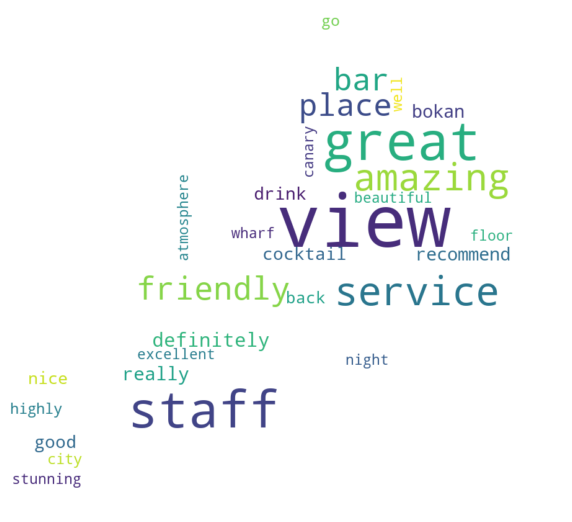

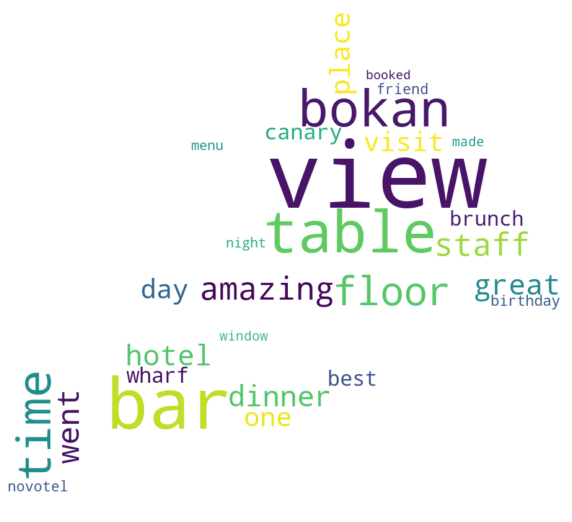

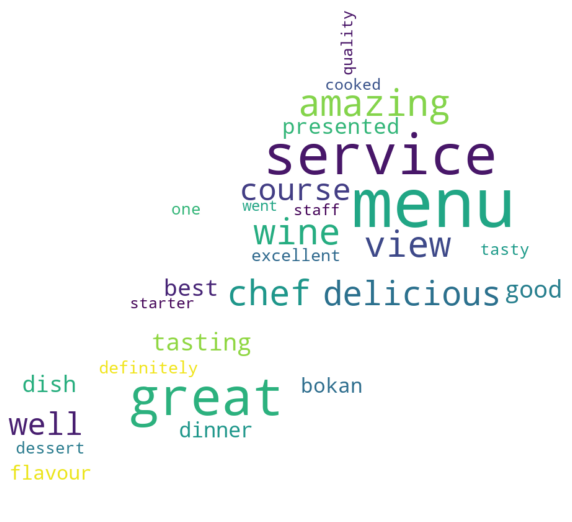

In [185]:
for i in range(3):
    cluster = ' '.join(list(map(lambda x : x[1]*(x[0]+' '), cluster_bokan_good[i])))
    from_corpus_to_word_cloud(cluster,'waiter.jpg')

In [137]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)


def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1  # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()